In [1]:
# credit : https://avandekleut.github.io/vae/

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()


train_data = tv.datasets.FashionMNIST('./data', train=True, download=True,
                            transform=tv.transforms.ToTensor())
test_data = tv.datasets.FashionMNIST('./data', train=False,
                           transform=tv.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kld = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kld = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims, input_size):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, input_size)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        shape = int(np.sqrt(input_size))
        return z.reshape((-1, 1, shape, shape)) # output is gray scale

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_size):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_size)
        self.decoder = Decoder(latent_dims, input_size)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(model, data, epochs=20):
    opt = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = ((x - x_hat)**2).sum() + model.encoder.kld
            loss.backward()
            opt.step()
    return model

In [9]:
def plot_latent(model, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

def plot_reconstructed(model, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [8]:
latent_dims = 2
input_size = 28*28
vae = VariationalAutoencoder(latent_dims, input_size).to(device)
vae = train(vae, train_loader)

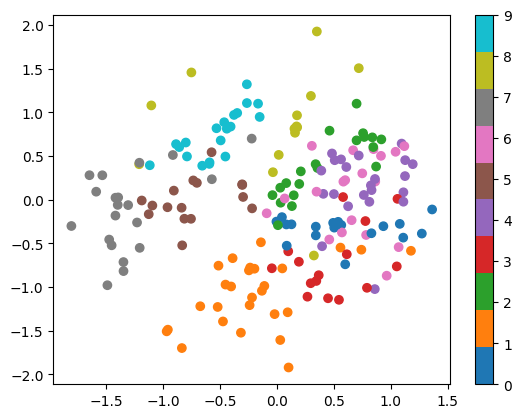

In [10]:
plot_latent(vae, train_loader, 1)

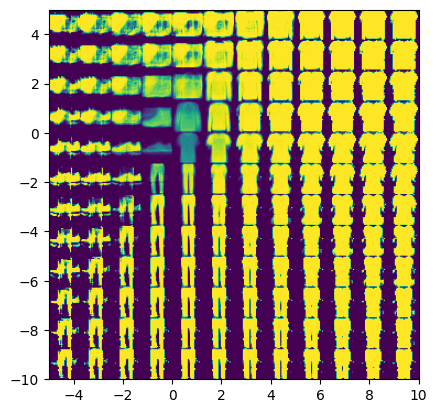

In [11]:
plot_reconstructed(vae)